## III.1 SPINN vs PINN on 2D Elastic Plate

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
import numpy as np

import phd.models.cm.analytical_plate as ap
from phd.config import load_config, copy_config, apply_overrides
from phd.plot.plot_cm import plot_field

from phd.plot import get_current_config as plt_cfg, book_config, book_compact_config, A4_config
book_config.set_as_current()
page_width = plt_cfg().page_width
# Configuration
save_fig = True
save_table = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [2]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (disp.)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (disp.)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed


W0109 13:02:40.661848   23842 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0109 13:02:40.666322   23730 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


Saved: './images/forward_mixed_metrics.png'


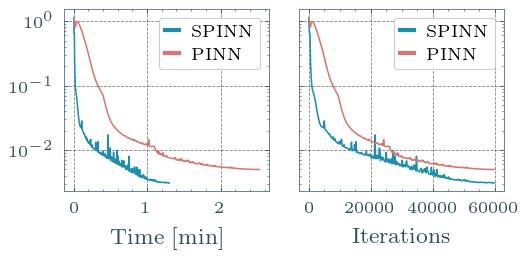

In [3]:
# SPINN vs PINN mixed comparison plots
results_mixed = {
    k: v for k, v in results_forward.items() if "mixed" in k
}
config_text_dict_mixed = {
    "spinn_mixed": "SPINN",
    "pinn_mixed": "PINN",
}

book_config.set_as_current()
plt_config = plt_cfg()
plt_config.min_font_size = plt_config.axes_font_size # increase legend font size
plt_config.set_as_current()

if results_forward:
    page_width = plt_cfg().page_width
    fig, axes = plt.subplots(1, 2, figsize=(page_width*0.6, page_width * 0.25), dpi=200, gridspec_kw={'wspace': 0.15}, sharey=True)
    for ax, step_type in zip(axes, ["time","iterations"]):

        ap.plot_metrics_comparison(
            results_mixed, metric_name="L2 Error", 
            run_names=[config_text_dict_mixed.get(k, k) for k in results_mixed.keys()],
            step_type=step_type, time_unit="min", ylabel="", ax=ax
        )
    book_config.set_as_current() # reset to default after changing font size
    if save_fig:
        os.makedirs('./images/pgf', exist_ok=True)
        fig.savefig(f'./images/pgf/forward_mixed_metrics.pgf', bbox_inches='tight')
        fig.savefig(f'./images/forward_mixed_metrics.png', dpi=300, bbox_inches='tight')
        print(f"Saved: './images/forward_mixed_metrics.png'")